In [ ]:
# default_exp core

# relational

> This module implements a single function containing the relational block from [A simple neural network module for relational reasoning][relational].

[relational]: https://arxiv.org/abs/1706.01427

In [ ]:
#hide
from nbdev.showdoc import *

I'm going to show that this works with Numpy and PyTorch without doing anything else:

In [ ]:
#hide
!pip install torch==1.8.1+cpu -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
  Using cached https://download.pytorch.org/whl/cpu/torch-1.8.1%2Bcpu-cp39-cp39-linux_x86_64.whl (169.1 MB)
  Using cached typing_extensions-3.10.0.0-py3-none-any.whl (26 kB)


In [ ]:
import torch
import numpy as np

Agnostic `cat`
-------------------

I need an agnostic cat function that's going to produce concatenated arrays or tensors regardless of what's passed. Also, using this hack so it doesn't care if Numpy or PyTorch aren't installed.

In [ ]:
#export
try:
    import torch
except ImportError:
    pass
try:
    import numpy as np
except ImportError:
    pass
from einops import rearrange, repeat, reduce

def cat(xs, axis):
    try:
        return torch.cat(xs, axis)
    except TypeError:
        return np.concatenate(xs, axis=axis)

Showing that this works with either arrays or tensors:

In [ ]:
np.random.seed(0)
xs = [np.random.randn(2,2) for _ in range(4)]
c = cat(xs, 1)
c

array([[ 1.76405235,  0.40015721,  1.86755799, -0.97727788, -0.10321885,
         0.4105985 ,  0.76103773,  0.12167502],
       [ 0.97873798,  2.2408932 ,  0.95008842, -0.15135721,  0.14404357,
         1.45427351,  0.44386323,  0.33367433]])

In [ ]:
xs = [torch.tensor(x) for x in xs]
_c = cat(xs, 1)
assert np.abs(c - _c.numpy()).max() < 1e-3
_c

tensor([[ 1.7641,  0.4002,  1.8676, -0.9773, -0.1032,  0.4106,  0.7610,  0.1217],
        [ 0.9787,  2.2409,  0.9501, -0.1514,  0.1440,  1.4543,  0.4439,  0.3337]],
       dtype=torch.float64)

Pairing
--------

This is closely based on [Kai Arulkumaran's relation function][kai] so I'm going to test the results of einops operations against that code. The first function I need concatenates the cartesian product of pairs on the trailing dimension. Example of what a cartesian product is:

[kai]: https://github.com/Kaixhin/pytorch/blob/3e49e198c2351c24f32365713db9639d232b8e3e/torch/nn/functional.py

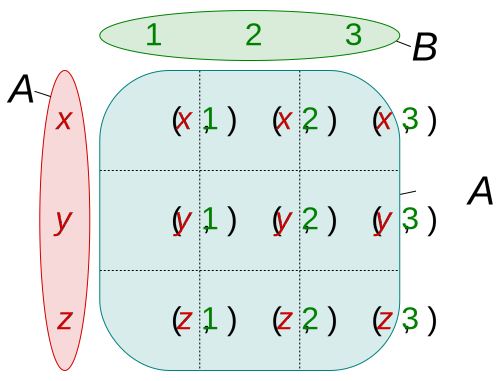

In [ ]:
import urllib
from IPython.display import display,SVG
u = "https://upload.wikimedia.org/wikipedia/commons/4/4e/Cartesian_Product_qtl1.svg"
with urllib.request.urlopen(u) as f:
    svg_string = f.read()
display(SVG(svg_string))

It might be possible to do this with [torch.cartesian_prod][prod] and [gather][] but it also needs to be batched. Instead, I do it here using repeat.

[gather]: https://pytorch.org/docs/stable/generated/torch.gather.html
[prod]: https://pytorch.org/docs/stable/generated/torch.cartesian_prod.html

In [ ]:
torch.manual_seed(0)
x = torch.randn(4,8,16)

Copying Kai's code and using einops:

In [ ]:
def kai_prodpair(x):
    b, o, c = x.shape
    return torch.cat((x.unsqueeze(1).expand(b, o, o, c).contiguous().view(b, o * o, c),
                      x.unsqueeze(2).expand(b, o, o, c).contiguous().view(b, o * o, c)), 2)

def prodpair(x):
    b, o, c = x.shape
    return cat([repeat(x, 'b o c -> b (m o) c', m=o),
                repeat(x, 'b o c -> b (o m) c', m=o)], 2)

I'm going to need to check if a lot of tensors are equal so we'll need this utility function:

In [ ]:
def allclose(a, b, epsilon=1e-3):
    return torch.abs(a - b).max() < epsilon

In [ ]:
assert allclose(kai_prodpair(x), prodpair(x))

I wanted to check if this was precisely a cartesian product, but it's not because of the order of the arguments into `cat`.

In [ ]:
def cartesian_trailing(x):
    out = []
    b, o, c = x.shape
    for i in range(b):
        for j in range(o):
            for k in range(o):
                a, b = x[i, j], x[i, k]
                out.append(rearrange(cat([a,b], 0), 'c2 -> () c2'))
    return rearrange(cat(out, 0), '(b osq) c2 -> b osq c2', osq=o**2, c2=2*c)

In [ ]:
eq = allclose(prodpair(x), cartesian_trailing(x))
print(f"Is prodpair a cartesian product? {'yes' if eq.item() else 'no'}")

Is prodpair a cartesian product? no


So, I'll reverse that for the implementation, just so I can say it's really a cartesian product.

In [ ]:
#export
def prodpair(x):
    """Creates cartesian pairwise matrix for each example in the minibatch,
    pairing vectors on the trailing dimension."""
    b, o, c = x.shape
    return cat([repeat(x, 'b o c -> b (o m) c', m=o),
                repeat(x, 'b o c -> b (m o) c', m=o)], 2)

In [ ]:
err = allclose(prodpair(x), cartesian_trailing(x))
assert err
print(f"Is prodpair a cartesian product now? {'yes' if err.item() else 'no'}")

Is prodpair a cartesian product now? yes


Append embedding
----------------------------

Relation networks need the option to add an embedding vector to each element.

In [ ]:
def kai_append_embedding(pairs, embedding):
    b, osq, c2 = pairs.shape
    return torch.cat((pairs, embedding.unsqueeze(1).expand(b, osq, embedding.size(1))), 2)

In [ ]:
#export
def append_embedding(pairs, embedding):
    """Add an embedding to every paired token."""
    b, osq, c2 = pairs.shape
    return cat([pairs, repeat(embedding, 'b c -> b osq c', osq=osq)], 2)

Checking the einops version is correct:

In [ ]:
b, o, c = x.shape
pairs = prodpair(x)
embedding = torch.randn(b, c)
assert allclose(append_embedding(pairs, embedding), kai_append_embedding(pairs, embedding))

Applying `g`
-----------------

`g` is a function applied to all pairs and their embeddings. It's assumed to take a two dimensional tensor as input so the tensor is rearranged before and after applying it. All that's left to compute the relational function is to take the sum of the resulting representations over all pairs. I've added the option to reduce using `mean` instead if required using the kwarg `reduction`.

In [ ]:
#export
def relation(input, g, embedding=None, max_pairwise=None, reduction='sum'):
    r"""Applies an all-to-all pairwise relation function to a set of objects.
    See :class:`~torch.nn.Relation` for details.
    """
    # Batch size, number of objects, feature size
    b, o, c = input.shape
    # Create pairwise matrix
    pairs = prodpair(input)
    # Append embedding if provided
    if embedding is not None:
        pairs = append_embedding(pairs, embedding)
    # Calculate new feature size
    c = pairs.shape[2]
    # Pack into batches
    pairs = rearrange(pairs, 'b om c -> (b om) c') 
    # Pass through g
    if max_pairwise is None:
        output = g(pairs)
    else:
        outputs = []
        for batch in range(0, b * o ** 2, max_pairwise):
            outputs.append(g(pairs[batch:batch + max_pairwise]))
        output = torch.cat(outputs, 0)
    # Unpack
    output = reduce(output, '(b o2) c -> b c', reduction, o2=o**2)
    return output

Integration test
--------

Testing that the result of this function is equal to Kai's implementation. The only difference is the order of the pairs, and that doesn't affect the result.

In [ ]:
def kai_relation(input, g, embedding=None, max_pairwise=None):
    r"""Applies an all-to-all pairwise relation function to a set of objects.
    See :class:`~torch.nn.Relation` for details.
    """
    # Batch size, number of objects, feature size
    b, o, c = input.size()
    # Create pairwise matrix
    pairs = torch.cat((input.unsqueeze(1).expand(b, o, o, c).contiguous().view(b, o * o, c),
                       input.unsqueeze(2).expand(b, o, o, c).contiguous().view(b, o * o, c)), 2)
    # Append embedding if provided
    if embedding is not None:
        pairs = torch.cat((pairs, embedding.unsqueeze(1).expand(b, o ** 2, embedding.size(1))), 2)
    # Calculate new feature size
    c = pairs.size(2)
    # Pack into batches
    pairs = pairs.view(b * o ** 2, c)
    # Pass through g
    if max_pairwise is None:
        output = g(pairs)
    else:
        outputs = []
        for batch in range(0, b * o ** 2, max_pairwise):
            outputs.append(g(pairs[batch:batch + max_pairwise]))
        output = torch.cat(outputs, 0)
    # Unpack
    output = output.view(b, o ** 2, output.size(1)).sum(1).squeeze(1)
    return output

In [ ]:
def dummy_g(x):
    assert x.ndim == 2
    return x

In [ ]:
assert allclose(kai_relation(x, dummy_g), relation(x, dummy_g))

Is this agnostic to numpy?
-------------------------------------

The function works the same if I cast the input to be a numpy array.

In [ ]:
assert allclose(torch.tensor(relation(x.numpy(), dummy_g)), relation(x, dummy_g))